## Corpus Generation via ABsynth

### Import the absynth corpus generator

In [21]:
from absynth.lexicon import Vocabulary, LexiconGenerator
from absynth.sentence import SentenceGenerator, FrameManager
from absynth.corpus import SyntheticCorpusGenerator
from absynth.visualization import Visualizer

### Create generator with default settings

In [22]:
generator_default = SyntheticCorpusGenerator()
corpus_default = generator_default.generate_corpus(num_sentences=2000)

Generating 2000 sentences with semantic frame diversity...
Generated 1000 sentences...
Generated 2000 sentences...
Corpus generation complete: 2000 sentences


### Create generator with custom settings

In [23]:
# Create generator with custom settings 
vocab = Vocabulary({
    "noun":300, "transitive_verb":40, "intransitive_verb":25, 
    "communication_verb":20, "motion_verb":20, "change_verb":15, "adjective":40, 
    "adverb":25, "location":150, "temporal":35, "instrument":25, "preposition":15, 
    "conjunction":10, "determiner":8
})

In [24]:
lexicon = LexiconGenerator(
    vocab_sizes=vocab,           # Custom vocabulary sizes
    num_clusters=5,              # Number of semantic clusters to create
    zipfian_alpha=1.05,             # Alpha parameter for Zipfian distribution
    error_bias=0.00001,              # Error bias for word generation
    random_seed=42               # For reproducible generation
)

In [25]:
templates = FrameManager()
sentence_generator = SentenceGenerator(lexicon, templates)
generator_custom = SyntheticCorpusGenerator(lexicon=lexicon, sentence_generator=sentence_generator)

In [26]:
corpus_custom = generator_custom.generate_corpus(
    num_sentences=2000,
    complexity_distribution={"simple": 0.55, "medium": 0.35, "complex": 0.10},
    semantic_frame_distribution={
        "transitive_action": 0.1,
        "transitive_with_location": 0.15,
        "motion_with_source": 0.15,
        "temporal_action": 0.15,
        "instrumental_action": 0.15,
        "multi_action": 0.15,
        "temporal_complex": 0.15,
    }
)

Generating 2000 sentences with semantic frame diversity...
Generated 1000 sentences...
Generated 2000 sentences...
Corpus generation complete: 2000 sentences


### Evaluate quality

In [27]:
evaluation_default = generator_default.evaluate_corpus(corpus_default, calculate_suitability=True)

Analyzing 2000 sentences...
Corpus evaluation complete:
  Suitability score: 0.67 (good)

Recommendations:
  1. Increase entropy variation for diverse prediction challenges (std: 0.48, target: >0.5)


In [28]:
evaluation_custom = generator_custom.evaluate_corpus(corpus_custom, calculate_suitability=True)

Analyzing 2000 sentences...
Corpus evaluation complete:
  Suitability score: 0.72 (good)


### Save corpus


In [29]:
corpus_custom.save("corpus_full.json", indent=2)
corpus_custom.export("corpus_semantic.json", format="semantic_annotations", indent=2) 
corpus_custom.export("corpus_sentences.json", format="sentences_only", indent=2)

### Visualize the corpus statistics

Analyzing 2000 sentences...
Corpus evaluation complete:
  Suitability score: 0.67 (good)

Recommendations:
  1. Increase entropy variation for diverse prediction challenges (std: 0.48, target: >0.5)


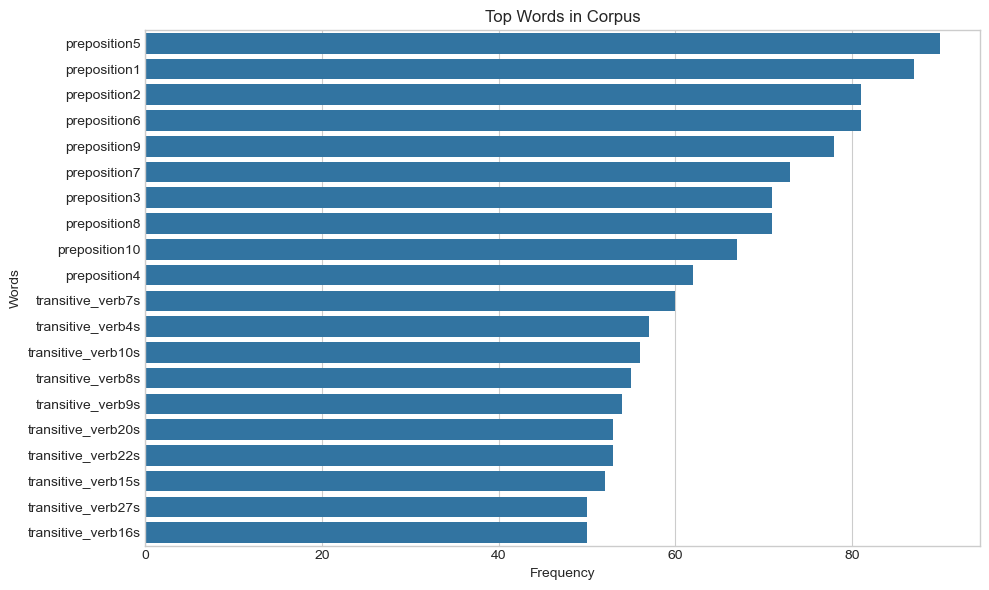

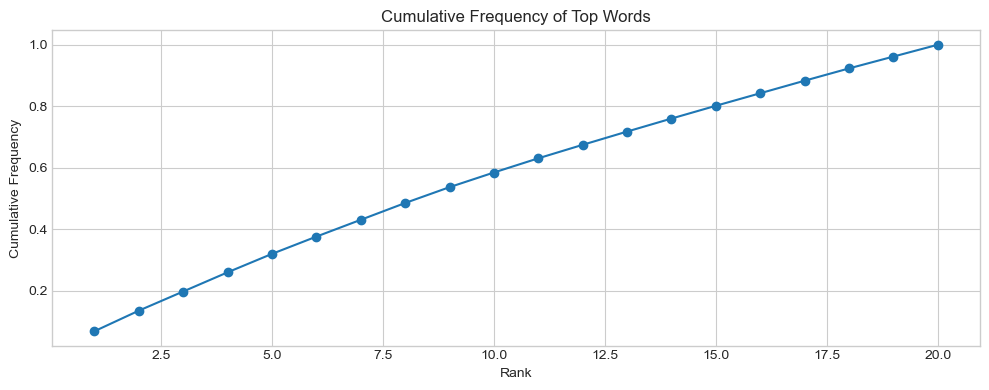

Total Words: 7522, Unique Words: 456, Type-Token Ratio: 0.06


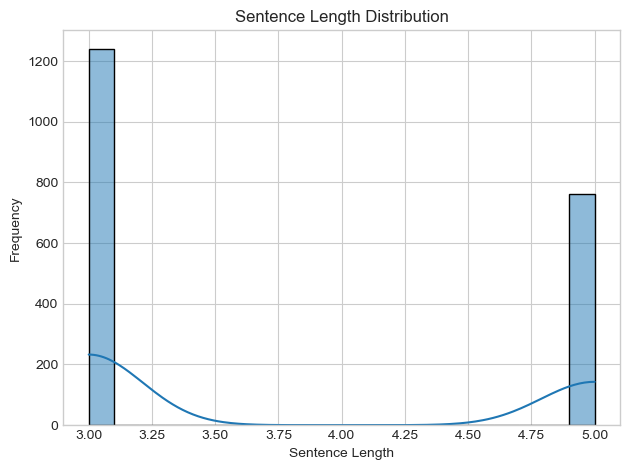

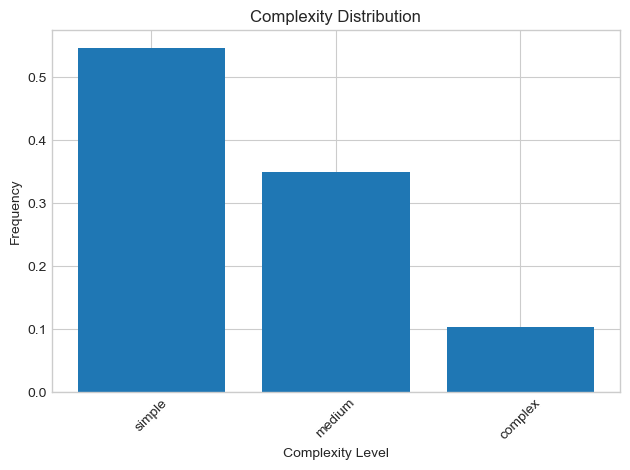

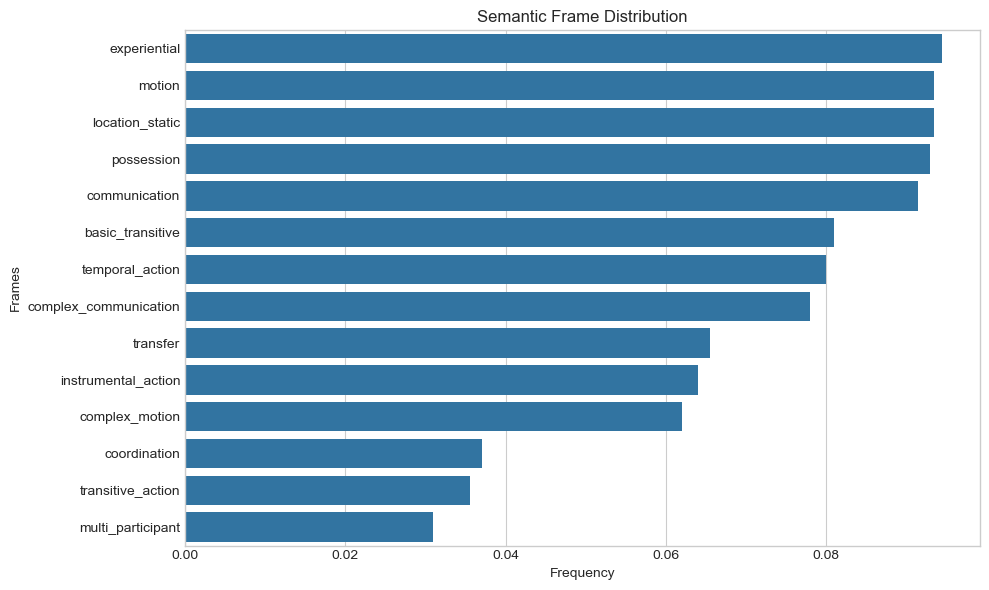

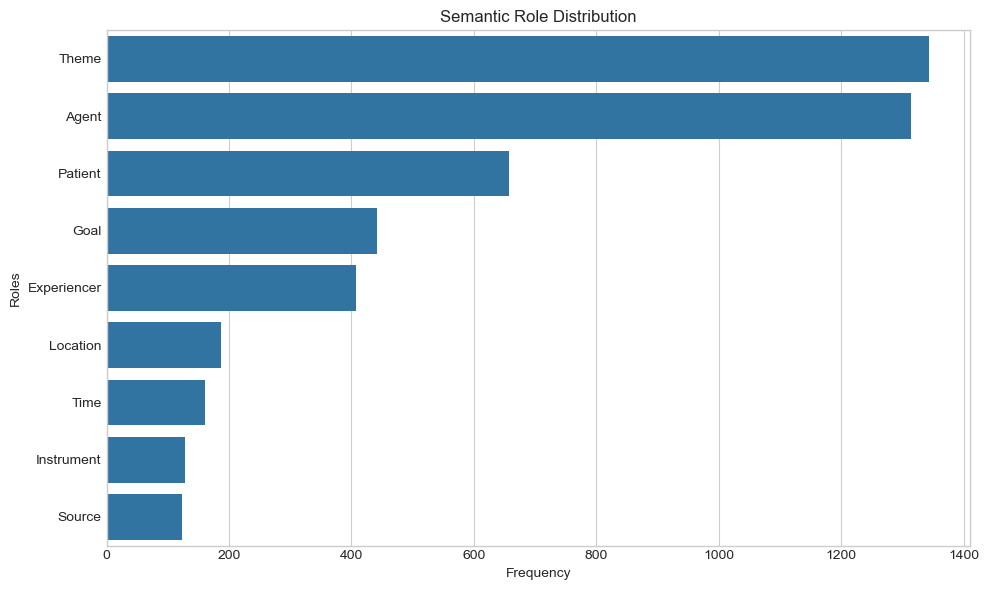

Avg Arguments per Sentence: 2.38


In [30]:
visualizer = Visualizer(log_dir='./plots')
visualizer.visualize(corpus_default)

Analyzing 2000 sentences...
Corpus evaluation complete:
  Suitability score: 0.72 (good)


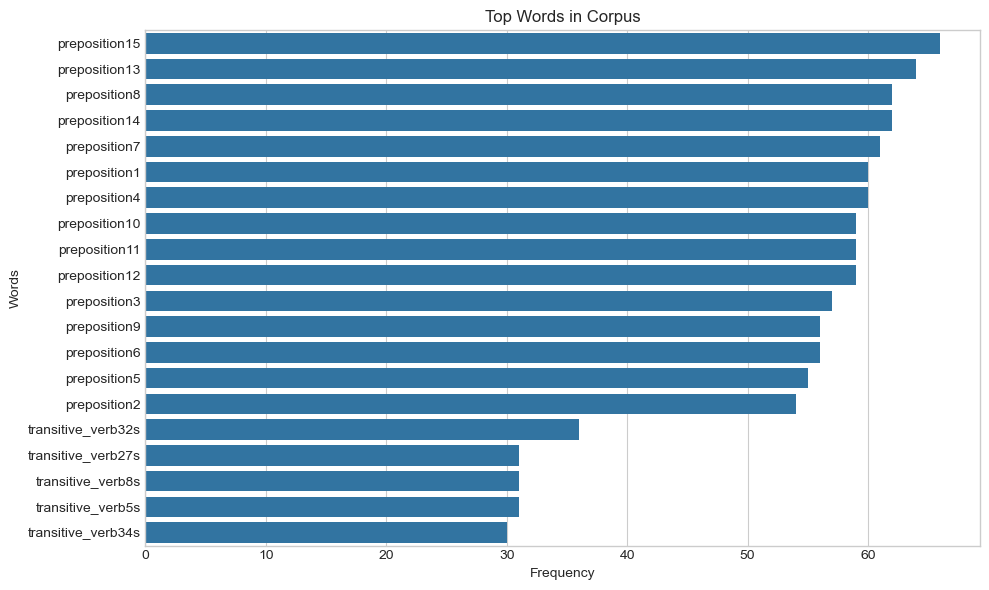

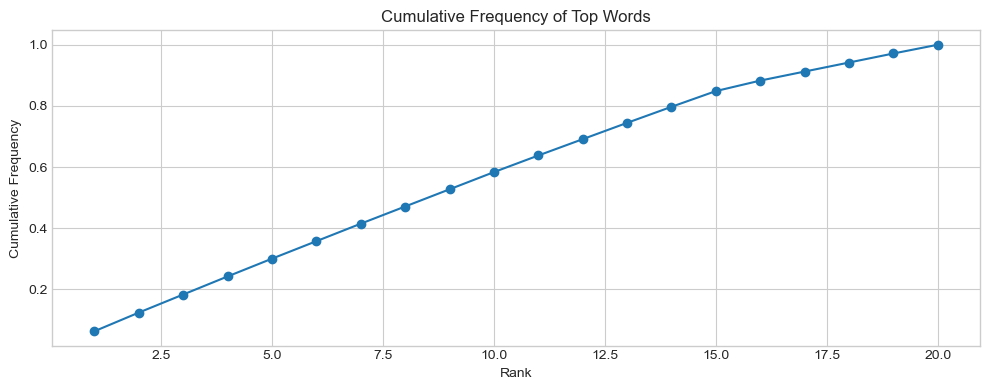

Total Words: 8342, Unique Words: 774, Type-Token Ratio: 0.09


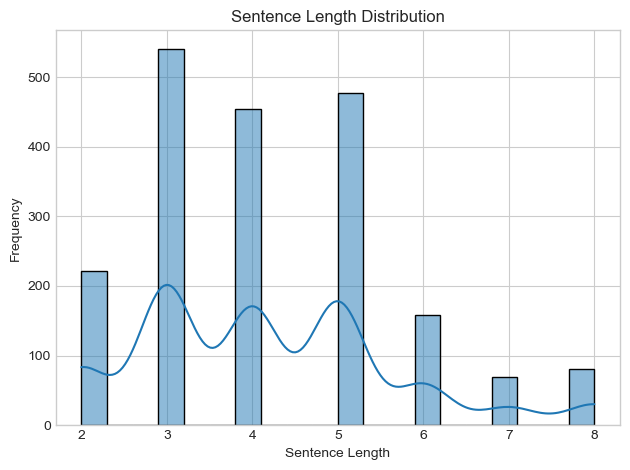

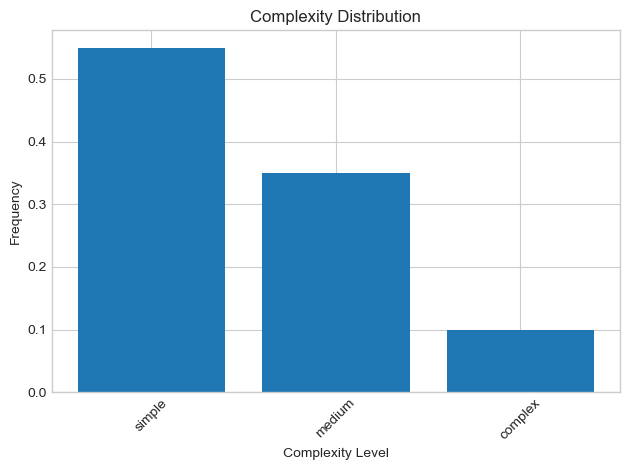

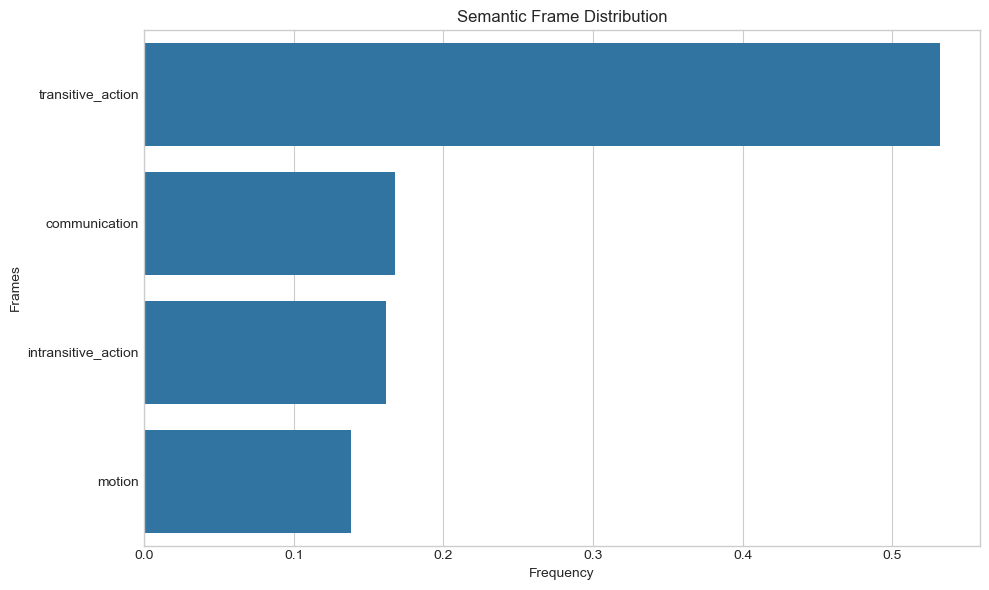

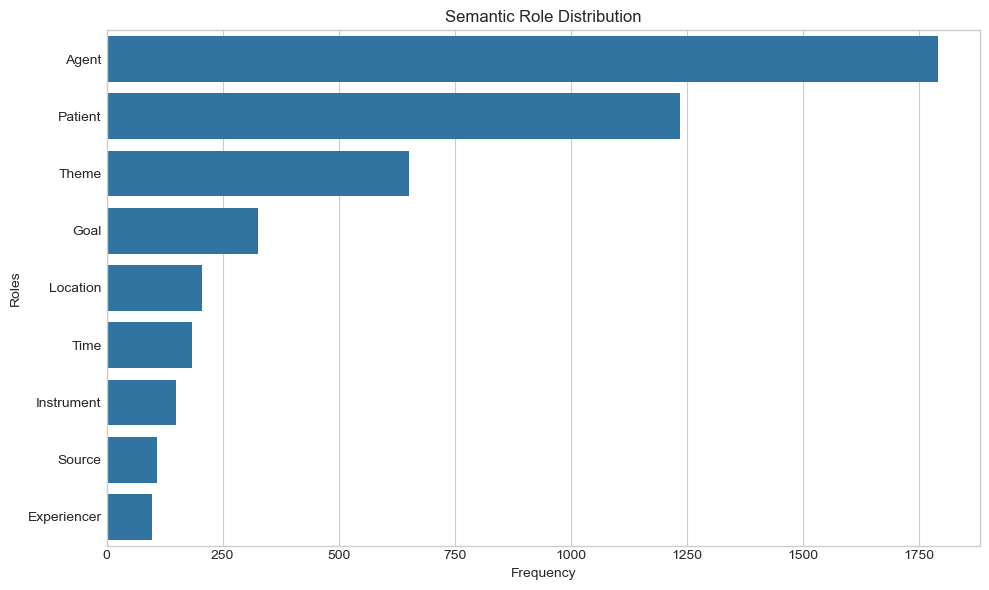

Avg Arguments per Sentence: 2.38


In [31]:
visualizer = Visualizer(log_dir='./plots')
visualizer.visualize(corpus_custom)

# TRACE for Model Analysis

## Tokenizer creation and data loading 

In [32]:
from trace.tokenizer import create_tokenizer_from_data
CORPUS_PATH = "./data/corpus.json"  
tokenizer = create_tokenizer_from_data(vocab_file=CORPUS_PATH)  
VOCAB_SIZE = tokenizer.get_vocab_size()

ModuleNotFoundError: No module named 'trace.tokenizer'; 'trace' is not a package

In [33]:
from trace.dataloader import get_dataloader
train_loader, val_loader, test_loader = get_dataloader(
    corpus_path=CORPUS_PATH,
    tokenizer=tokenizer,
    batch_size=32,
    max_length=16,
    val_split=0.1,
    test_split=0.1
)

ModuleNotFoundError: No module named 'trace.dataloader'; 'trace' is not a package

## Building a transformer 

In [34]:
# Create transformer model
from trace.transformer import Transformer, TransformerConfig

model_config = TransformerConfig(
    model_type="decoder_only",  # "encoder_only", "decoder_only", "encoder_decoder"
    vocab_size=VOCAB_SIZE,
    d_model=96,  # Hidden dimension
    num_heads=3,  # Attention heads
    num_decoder_layers=2,  # Number of layers
    d_ff=384,  # Feed-forward dimension
    max_seq_length=16,  # Maximum sequence length
    dropout=0.1,
    device="cpu"  # "cpu" or "cuda"
)

ModuleNotFoundError: No module named 'trace.transformer'; 'trace' is not a package

In [35]:
model = Transformer.from_config(model_config)

NameError: name 'Transformer' is not defined

In [36]:
model

NameError: name 'model' is not defined